In [17]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from reachability.envs.simple import Workspace2D
from reachability.envs.rotary_link import RotaryLinkEnv
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: title={'center': 'RotaryLinkEnv: ψ=2.5°, θ1=49.5°, θ2=257.5°'}, xlabel='X (Global)', ylabel='Y (Global)'>

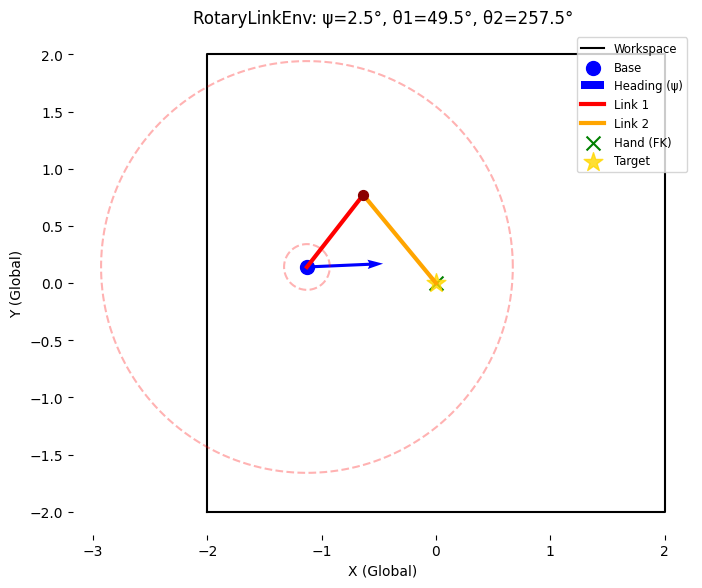

In [2]:
# Create workspace
workspace = Workspace2D(-2, 2, -2, 2)
env = RotaryLinkEnv(workspace, link_lengths=[0.8, 1.0], joint_limits=None, n_links=2, base_pos_eps=0.3, base_heading_stddev=np.pi/12) #joint_limits=[[-np.pi, np.pi], [-np.pi, np.pi]],

rng = np.random.default_rng(0)
h_world = np.array([[0, 0]], dtype=np.float32)
q_sample_world = env.sample_q_given_h_uniform(h_world, rng)

env.plot(q_sample_world.flatten(), h_world)

## Data distribution visualization

In [3]:
def plot_data_distribution(bx, by, psi, th1, th2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Plot 1: Workspace density (should be a donut around H) - scatter plot of base positions
    ax1.scatter(bx, by, s=1, alpha=0.5, color='blue', label="Base Positions")
    
    # Add orientation arrows for a subset to keep it readable
    skip = n_samples // 100 # Show ~100 arrows
    ax1.quiver(bx[::skip], by[::skip], np.cos(psi[::skip]), np.sin(psi[::skip]), 
               color='red', scale=15, width=0.005, label="Orientation (ψ)")
    
    # Mark target H
    ax1.scatter([0], [0], marker="*", s=200, color='gold', edgecolor='black', zorder=5, label="Target H=(0,0)")
    
    ax1.set_aspect('equal')
    ax1.set_title("Plot 1: Base Distribution (donut)")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.legend()

    # Plot 2: Joint mode visualization
    two_pi = 2.0 * np.pi
    ax2.set_xlim(0, two_pi)
    ax2.set_ylim(0, two_pi)
    ax2.scatter(th1, th2, s=5, alpha=0.4, color='purple')

    ticks = [0, np.pi/2, np.pi, 1.5*np.pi, two_pi]
    labels = ['0', 'π/2', 'π', '3π/2', '2π']
    ax2.set_xticks(ticks)
    ax2.set_xticklabels(labels)
    ax2.set_yticks(ticks)
    ax2.set_yticklabels(labels)
    
    ax2.set_title("Plot 2: Joint Modes (θ1 vs θ2)")
    ax2.set_xlabel("θ1 (Shoulder)")
    ax2.set_ylabel("θ2 (Elbow)")
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

In [4]:
# Data to test on
n_samples = 2000
h_world_example = np.zeros((n_samples, 2), dtype=np.float32)

### Empirical data distribution

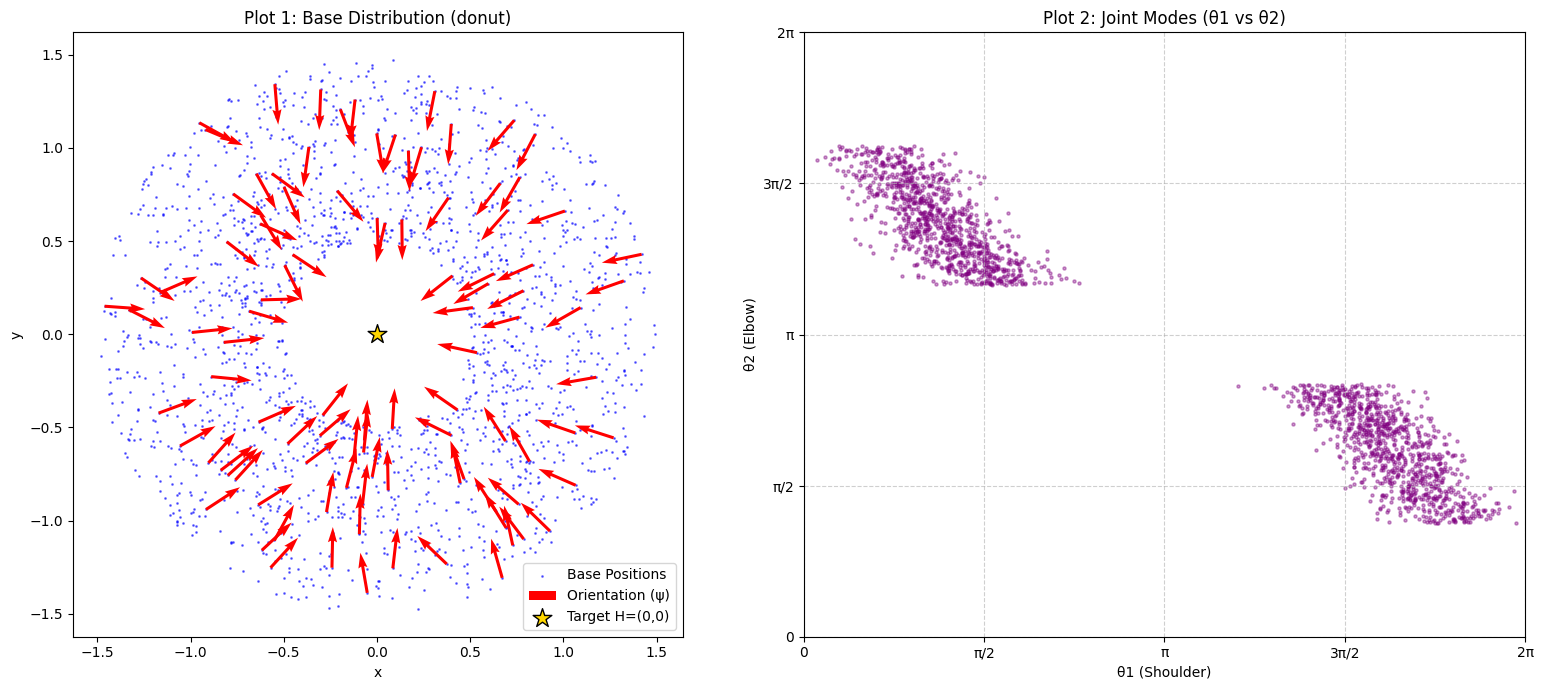

In [5]:
# 1. Generate 2000 samples for a fixed target at the origin
Q_samples = env.sample_q_given_h_uniform(h_world_example, rng)

# Extract components for plotting -> Q columns: [x, y, psi, th1, th2]
bx = Q_samples[:, 0]
by = Q_samples[:, 1]
psi = Q_samples[:, 2]
th1 = Q_samples[:, 3]
th2 = Q_samples[:, 4]

plot_data_distribution(bx, by, psi, th1, th2)

### Nearest neighbors baseline sampled data distribution

/Users/niu/projects/reachability_tests/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


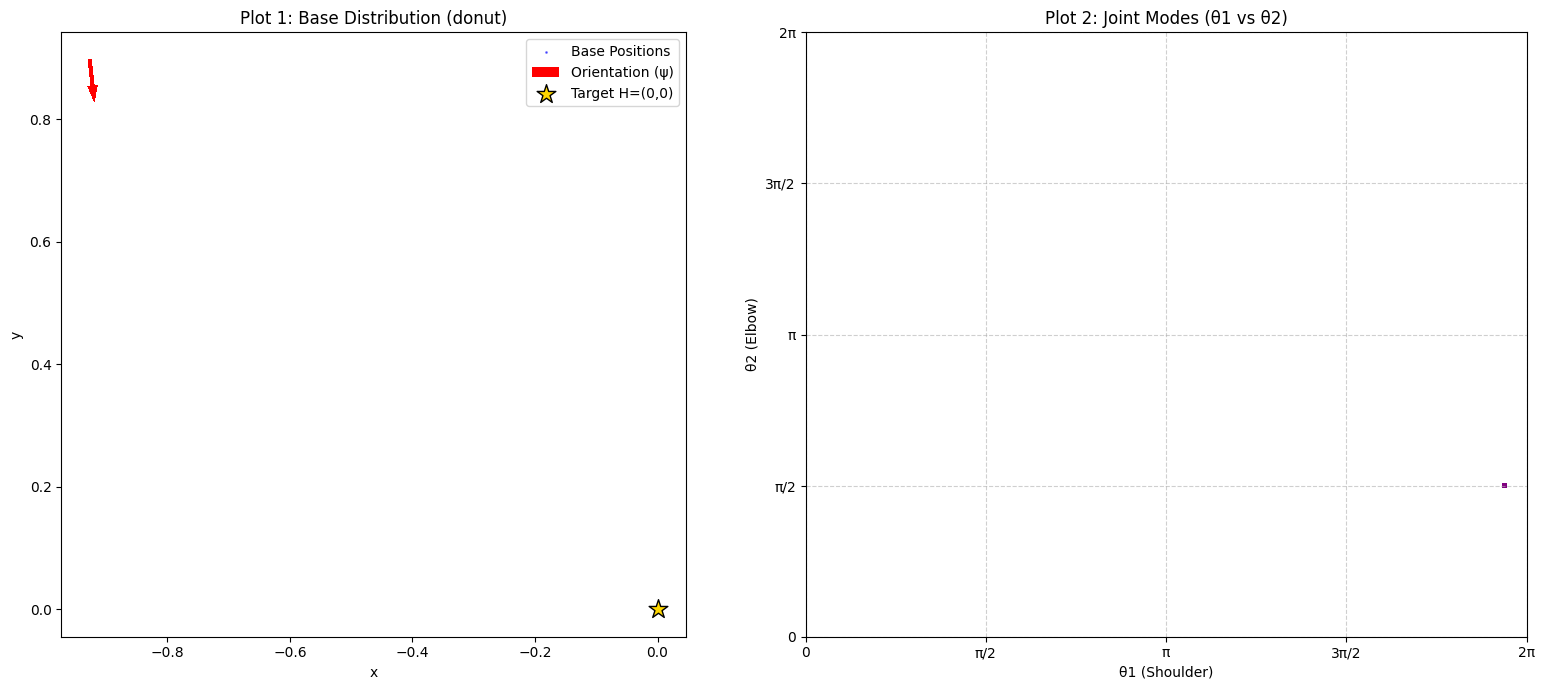

In [6]:
import joblib
nn_trained_model = joblib.load("outputs/model_ckpts/nn_baseline/nn_baseline_rotarylink.pt")

# 1. Generate 2000 samples for a fixed target at the origin
Q_samples = nn_trained_model.sample(h_world_example, h_world_example, n_samples, rng)

# Extract components for plotting -> Q columns: [x, y, psi, th1, th2]
bx = Q_samples[:, :, 0]
by = Q_samples[:, :, 1]
psi = Q_samples[:, :, 2]
th1 = Q_samples[:, :, 3]
th2 = Q_samples[:, :, 4]

plot_data_distribution(bx, by, psi, th1, th2)

<Axes: title={'center': 'RotaryLinkEnv: ψ=276.4°, θ1=348.6°, θ2=90.3°'}, xlabel='X (Global)', ylabel='Y (Global)'>

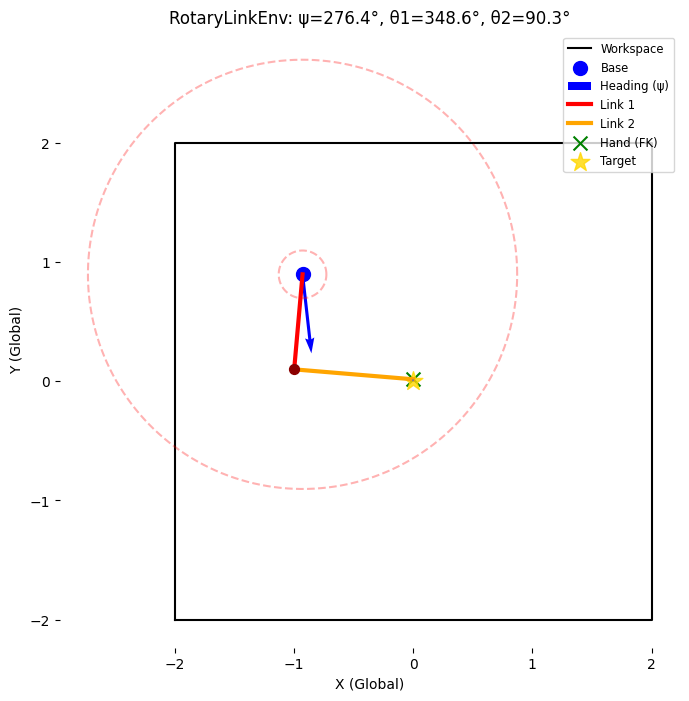

In [8]:
# Plotting sampling
Q = nn_trained_model.sample(h_world_example, h_world_example, 1, rng)
env.plot(Q.flatten(), h_world_example)

## New environment
(To experiment with changing workspace sizes and see if model checkpoint generalizes)

In [8]:
new_workspace = Workspace2D(-5, 5, -5, 5)
new_env = RotaryLinkEnv(new_workspace, link_lengths=[0.8, 1.0], joint_limits=None, n_links=2, base_pos_eps=0.3, base_heading_stddev=np.pi/12) #joint_limits=[[-np.pi, np.pi], [-np.pi, np.pi]]

### cVAE sampled data distribution

num params in encoder =  2118156
num params in decoder =  8435216
inference speed per sample (seconds):  1.805102825164795e-05


<Axes: title={'center': 'RotaryLinkEnv: ψ=96.1°, θ1=285.0°, θ2=121.1°'}, xlabel='X (Global)', ylabel='Y (Global)'>

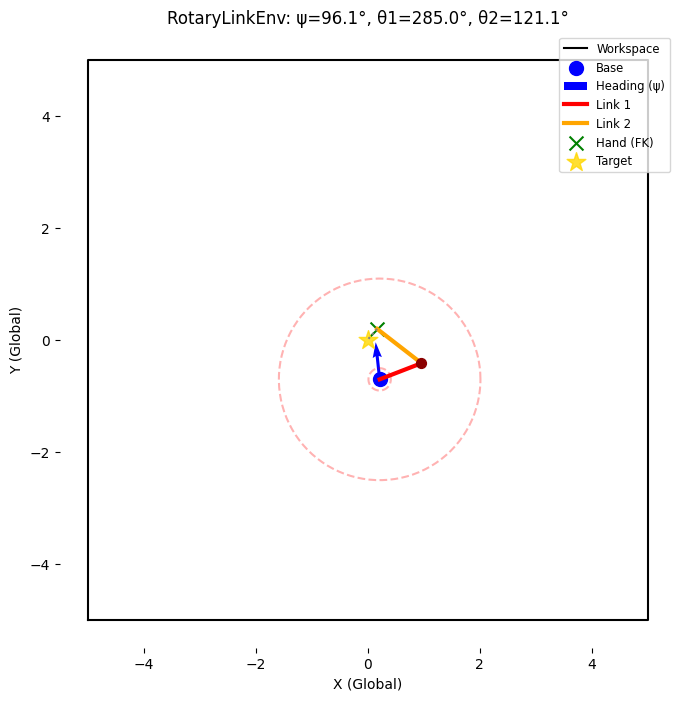

In [18]:
from reachability.models.cvae import CVAEConditionalSampler
cvae_model_path = "outputs/model_ckpts/cvae/cvae_rotary_1262026_controlledparams.pt"
cvae_model = CVAEConditionalSampler.load(new_env, cvae_model_path, device="cpu")

# 1. Generate 2000 samples for a fixed target at the origin
start = time.time()
Q_samples = cvae_model.sample(h_world_example, h_world_example, n_samples=1, rng=rng)
print("inference speed per sample (seconds): ", (time.time() - start)/h_world_example.shape[0])
new_env.plot(Q_samples[0].flatten(), h_world_example)

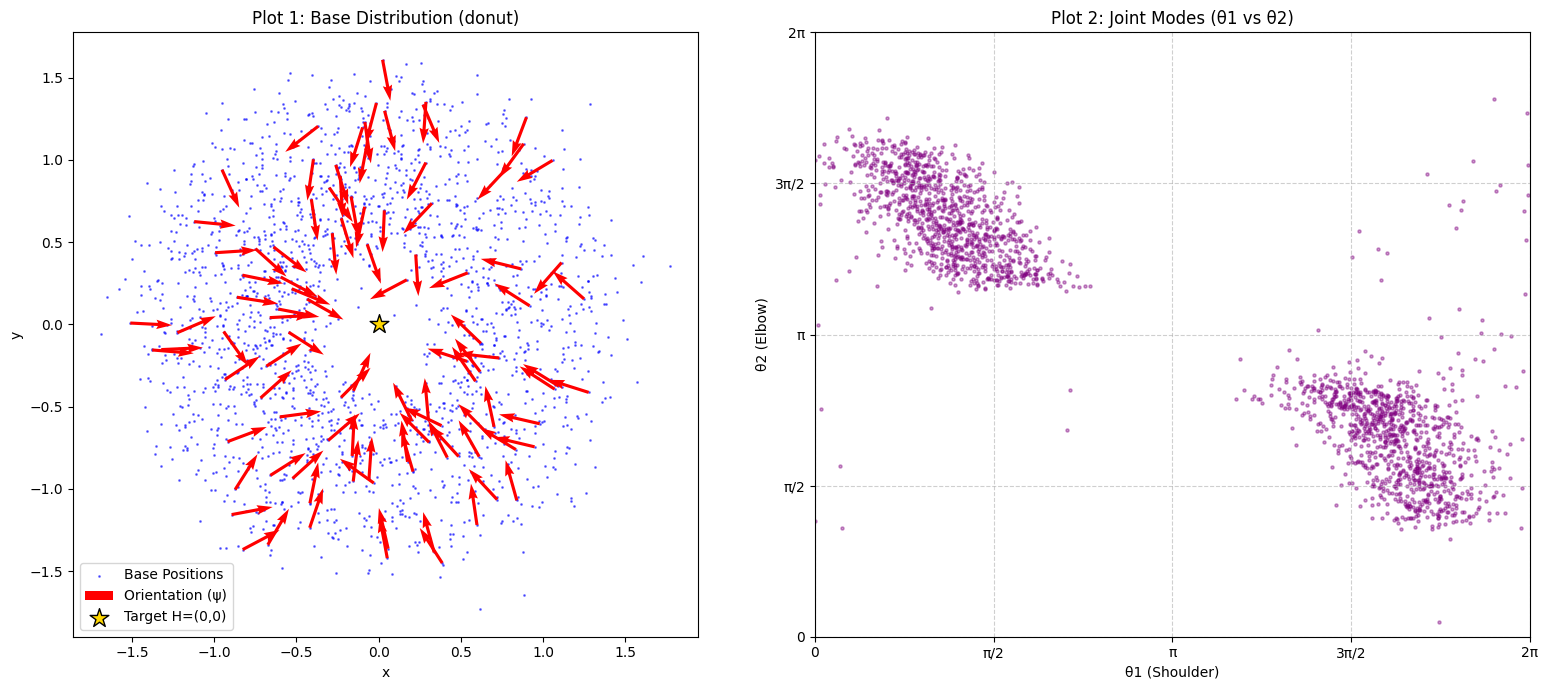

In [10]:
# Extract components for plotting -> Q columns: [x, y, psi, th1, th2]
bx = Q_samples[:, :, 0]
by = Q_samples[:, :, 1]
psi = Q_samples[:, :, 2]
th1 = Q_samples[:, :, 3]
th2 = Q_samples[:, :, 4]

plot_data_distribution(bx, by, psi, th1, th2)

### cINN sampled data distribution

DEBUG: q_sample_feat.squeeze(1) shape from model: torch.Size([2000, 8])
DEBUG: q_sample_world shape after conversion: (2000, 5)
inference speed per sample (seconds):  3.0367016792297363e-05


<Axes: title={'center': 'RotaryLinkEnv: ψ=142.9°, θ1=5.1°, θ2=290.2°'}, xlabel='X (Global)', ylabel='Y (Global)'>

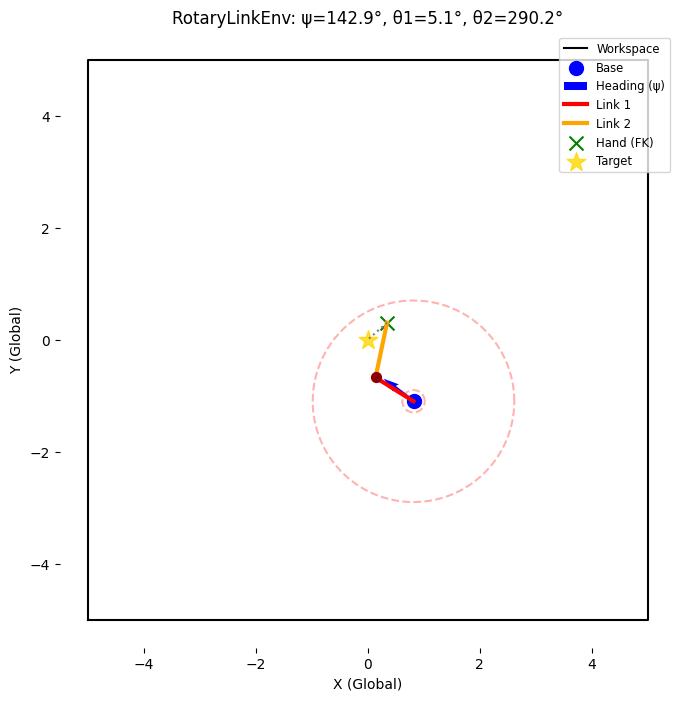

In [19]:
from reachability.models.cinn import CINNConditionalSampler
cinn_model_path = "outputs/model_ckpts/cinn/cinn_rotary_1262026_controlledparams.pt"
cinn_model = CINNConditionalSampler.load(new_env, cinn_model_path, device="cpu")

# 1. Generate 2000 samples for a fixed target at the origin
start = time.time()
Q_samples = cinn_model.sample(h_world_example, h_world_example, n_samples=1, rng=rng, sampling_temperature=0)
print("inference speed per sample (seconds): ", (time.time() - start)/h_world_example.shape[0])

new_env.plot(Q_samples[0].flatten(), h_world_example)

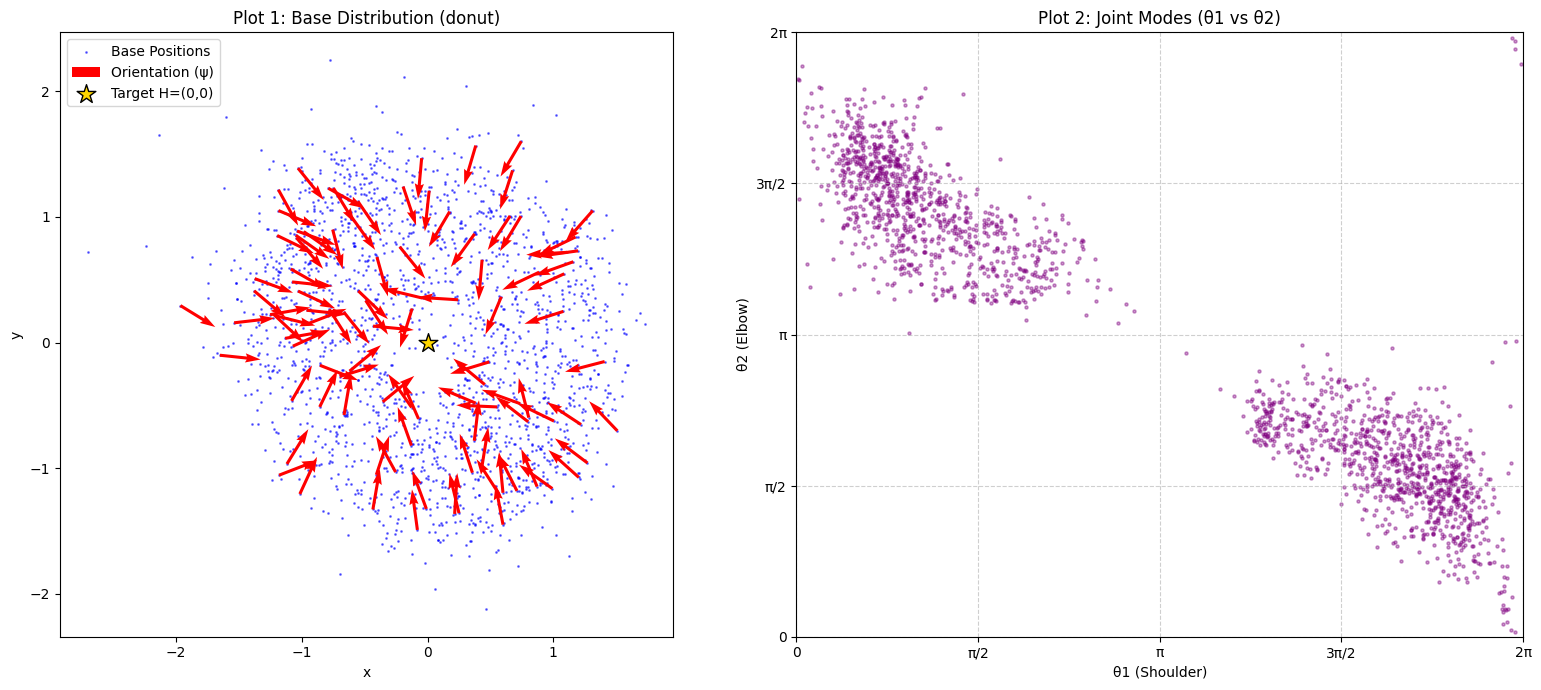

In [13]:
# Extract components for plotting -> Q columns: [x, y, psi, th1, th2]
bx = Q_samples[:, :, 0]
by = Q_samples[:, :, 1]
psi = Q_samples[:, :, 2]
th1 = Q_samples[:, :, 3]
th2 = Q_samples[:, :, 4]

plot_data_distribution(bx, by, psi, th1, th2)

### Conditional diffusion sampled data distribution

q_sample_feat shape from model: torch.Size([2000, 8])
q_sample_world shape: (2000, 5)
inference speed per sample (seconds):  0.0008506549596786499


<Axes: title={'center': 'RotaryLinkEnv: ψ=48.2°, θ1=55.7°, θ2=269.4°'}, xlabel='X (Global)', ylabel='Y (Global)'>

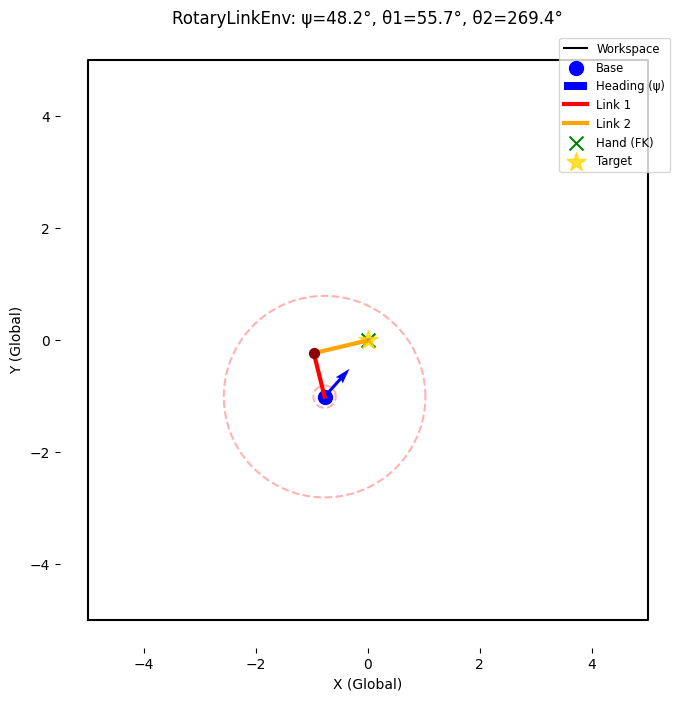

In [21]:
from reachability.models.cdiffusion import DiffusionConditionalSampler
cdiffusion_model_path = "outputs/model_ckpts/cdiffusion/cdiffusion_rotary_1262026_controlledparams.pt"
cdiffusion_model = DiffusionConditionalSampler.load(new_env, cdiffusion_model_path, device="cpu")

# 1. Generate 2000 samples for a fixed target at the origin
start = time.time()
Q_samples = cdiffusion_model.sample(h_world_example, h_world_example, n_samples=1, rng=rng, sampling_temperature=0)
print("inference speed per sample (seconds): ", (time.time() - start)/h_world_example.shape[0])

new_env.plot(Q_samples[0].flatten(), h_world_example)

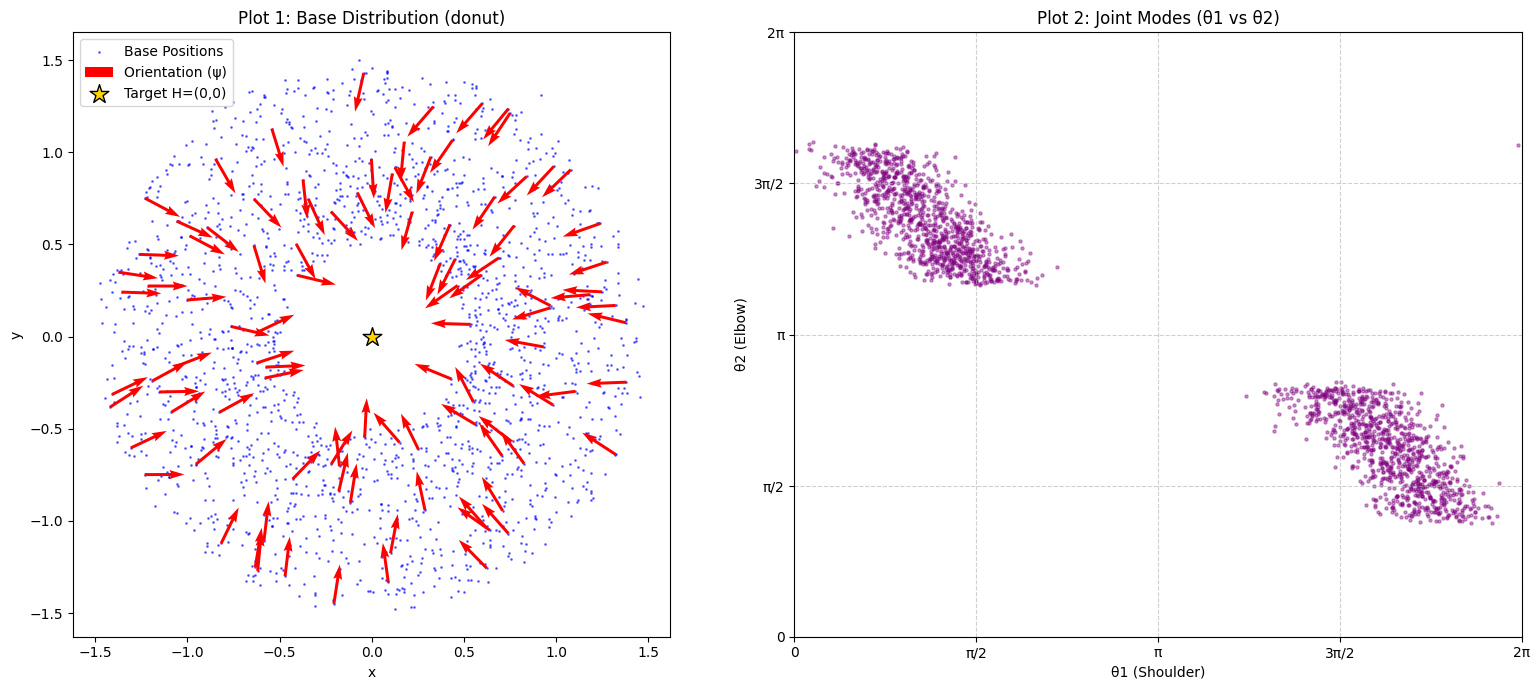

In [15]:
# Extract components for plotting -> Q columns: [x, y, psi, th1, th2]
bx = Q_samples[:, :, 0]
by = Q_samples[:, :, 1]
psi = Q_samples[:, :, 2]
th1 = Q_samples[:, :, 3]
th2 = Q_samples[:, :, 4]

plot_data_distribution(bx, by, psi, th1, th2)

## Comparing all the models

In [16]:
print("cVAE num parameters = ", cvae_model.count_parameters())
print("cINN num paramters = ", cinn_model.count_parameters())
print("cDiffusion num parameters = ", cdiffusion_model.count_parameters())

cVAE num parameters =  10553372
cINN num paramters =  8560896
cDiffusion num parameters =  8563592


### Computing number of params for `RotaryLinkEnv`

In [65]:
# aim: find model configs s.t. equal number params at inference for cVAE, cINN, and cDiffusion
hidden_dim = 512
d_c_feat, d_q_feat = 2, 8


# --- cVAE ---
z_dim = 6
num_blocks = 4
P_encoder_cvae = (
    hidden_dim * ((d_c_feat + d_q_feat) + 2 * num_blocks * (hidden_dim + 2) + 2 * z_dim + 3)
    + 2 * z_dim
)
print("P_encoder_cvae = ", P_encoder_cvae)
num_blocks = 16
P_decoder_cvae = (
    hidden_dim * ((d_c_feat + z_dim) + 2 * num_blocks * (hidden_dim + 2) + 2 * d_q_feat + 3)
    + 2 * d_q_feat
)
print("P_decoder_cvae = ", P_decoder_cvae)
print("P_total_cvae = ", P_encoder_cvae + P_decoder_cvae)

# --- cINN ---
num_subnet_blocks = 1
num_blocks = 8
P_total_cinn = num_blocks * (
    2 * d_q_feat
    + 2 * (
        hidden_dim * (d_c_feat + 0.5 * d_q_feat + 2 * num_subnet_blocks * (hidden_dim + 3) + 3)
        + d_q_feat * (hidden_dim + 2)
    )
)
print("P_total_cinn = ", P_total_cinn) # off by the true number by a little bit likely due to FrEIA internal implementations, close enough for now

# --- Diffusion ---
# d_t must be defined separately (time embedding dimension)
d_t = 512 // 4  # example value, change as needed
num_blocks = 16
P_total_diffusion = (
    (4 * d_t**2 + 3 * d_t)
    + hidden_dim * (2 * d_q_feat + d_c_feat + d_t + 2 * num_blocks * (hidden_dim + 2) + 3)
    + d_q_feat
)
print("P_total_diffusion = ", P_total_diffusion)

# these are matched pretty evenly for num params at inference now! re-train with these

P_encoder_cvae =  2118156
P_decoder_cvae =  8435216
P_total_cvae =  10553372
P_total_cinn =  8577408.0
P_total_diffusion =  8563592


### Eval metrics

In [ ]:
from reachability.data.datasets import Dataset
from reachability.eval.eval_model import evaluate_model, EvalConfig
n_test = 1000
eval_config = EvalConfig(n_samples_per_h=200, n_bins_theta=72, eps_hist=1.0e-9, sampling_temperature=0)
h_world_test = Dataset.generate(env=new_env, n=n_test, rng=rng).h_world

In [52]:
evaluate_model(new_env, cdiffusion_model, h_world_test=h_world_test, c_world_test=h_world_test, cfg=eval_config, rng=rng)

q_sample_feat shape from model: torch.Size([200000, 8])
q_sample_world shape: (200000, 5)


{'hand_err/mean': 0.027817660942673683,
 'hand_err/median': 0.02426249533891678,
 'hand_err/p95': 0.06038171797990799,
 'coverage/max_gap_mean': 0.18949526271527,
 'coverage/max_gap_p95': 0.2703563690185547,
 'coverage/kl_to_uniform': 0.005073777368444939,
 'eval/theta_values': array([5.79557848, 1.08546138, 5.24256134, ..., 5.84323692, 2.63653946,
        2.67359972], shape=(200000,))}